# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [24]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [25]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [26]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [27]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [28]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [29]:
target = TuringTarget(stat_model);

In [30]:
mchmc = Sampler(0.0, sqrt(target.d)*0.01, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [31]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 79.98929828180427
eps: 0.125 --> VarE: 20.820009343045076
eps: 0.0625 --> VarE: 6.246323623398952
eps: 0.03125 --> VarE: 1.608354803451178


[ Info: Found eps ✅


10001-element Vector{Any}:
 [0.3979192039644589, 0.7368538605414748, 0.0, 15.57266860206643]
 [0.3979192039644589, 0.7368538605414748, 0.5120342621593927, 16.101765234876723]
 [0.4041506737310676, 0.7674762589542028, 0.5324903039441402, 15.518062200205899]
 [0.41604776098403407, 0.7963730029731282, -1.4644809222318198, 15.353160159437762]
 [0.42859762889350633, 0.7677537207414789, 0.37331988445997943, 16.28226276340776]
 [0.3993091808710238, 0.7786509365526088, 1.6950772261318576, 16.128144163124382]
 [0.38909534913413313, 0.7491172246076045, -1.4335174313332253, 14.915549231725738]
 [0.4096549912054117, 0.7255829173541307, -1.158880687220826, 16.062591540746563]
 [0.39875235026608197, 0.7548693463025029, 1.1873761657216981, 14.954275783686288]
 [0.403089671761612, 0.7239218077534614, -1.009366468452125, 16.189741099416874]
 [0.3904875148993139, 0.7525181037097217, 2.7636809341613606, 16.28506088063984]
 [0.3610170208067326, 0.7421232743249203, 1.2974754712546694, 17.31475080340211]
 [

In [79]:
param_names = target.vsyms
internal_names = [:E, :logp]
names = [param_names; internal_names]
samples = MCMCChains.concretize(samples_mchmc)
chain = MCMCChains.Chains(samples, names, (internals = internal_names,))
stats = summarize(chain)
ess = mean(stats[:, :ess])

361.3585651648925

2-element Vector{Float64}:
 358.9769720813822
 363.7401582484028

In [13]:
#plt.plot(samples_mchmc.E[8000:end])

In [14]:
#mean(samples_mchmc.E[8000:end])

In [15]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [16]:
Wms_mchmc = [sample[1] for sample in samples_mchmc.Ω]
s8s_mchmc = [sample[2] for sample in samples_mchmc.Ω];

LoadError: UndefVarError: `samples_mchmc` not defined

In [17]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

LoadError: UndefVarError: `Wms_mchmc` not defined

## AbstractMCMC

In [35]:
mchmc = Sampler(0.0, sqrt(target.d)*0.01, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [36]:
samples = sample(
    stat_model, mchmc, 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 85.40106814110241
eps: 0.125 --> VarE: 33.65693471318534
eps: 0.0625 --> VarE: 7.33779426917308
eps: 0.03125 --> VarE: 2.870429298634538
eps: 0.015625 --> VarE: 1.0230078796080608


[ Info: Found eps ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.54 seconds
Compute duration  = 1.54 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2482    0.0551     0.0006    0.0039    98.2359    1.0171     ⋯
          σ8    0.8559    0.0540     0.0005    0.0038   127.4114    1.0072     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1540    0.2086    0.2438    0.2832    0.3665
          σ8    0.7579    0.8171    0.8542    0.8915    0.9668


## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 9.68 seconds
Compute duration  = 9.68 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2536    0.0593     0.0006    0.0012   2454.2226    1.0000    ⋯
          σ8    0.8517    0.0545     0.0005    0.0010   2676.2786    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.356897  0.754874  16.7982  3.0  1.0  …  2.0  0.0  0.731089  0.731089
 0.386638  0.763995  16.5036  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.398764  0.788632  16.2518  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.181248  0.851034  17.3564  7.0  1.0     2.0  0.0  0.731089  0.731089
 0.202002  0.847555  18.2107  1.0  1.0     1.0  0.0  0.731089  0.731089
 0.27528   0.837888  18.7557  3.0  1.0  …  2.0  0.0  0.731089  0.731089
 0.276317  0.839473  18.7347  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.312922  0.816106  18.2917  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.323827  0.818671  18.0568  1.0  1.0     1.0  0.0  0.731089  

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

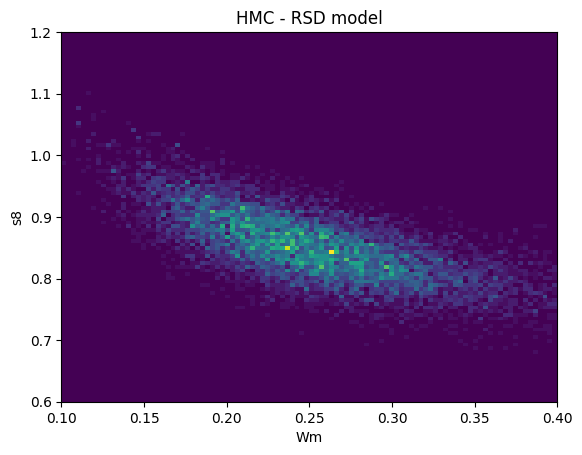

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");